# Домашнее задание №5

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

В этом домашнем задании вам предстоит обучить нейросеть на задачу предсказания героев сериала "Симпсоны".

Вам будет дан тренировочный и тестовый наборы данных. Вам нужно будет обучить нейросеть на тренировочных данных и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить на Я.Контест. Ваш балл за задание — значение метрики accuracy между предсказаниями вашей модели и правильными ответами на тестовый набор картинок. 

Ниже дан код скачивания и загрузки данных, с которыми вы будете работать. 

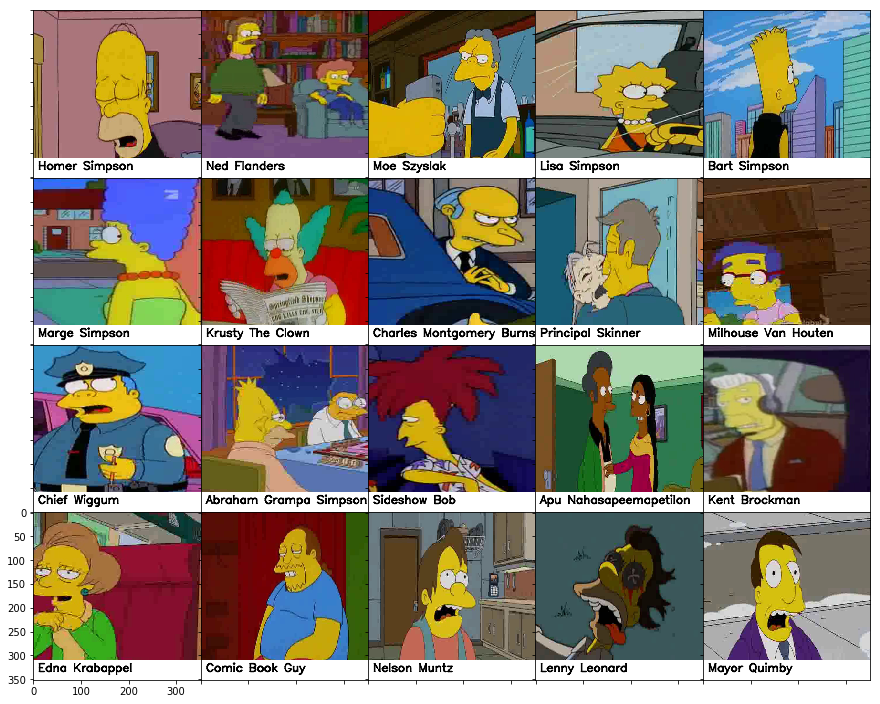

## Загрузка данных

Две ячейки ниже скачивают архив с данными и распаковывают этот архив. Не нужно менять эти ячейки.

In [ ]:
! pip install yandexdirect
! curl -L $(yadisk-direct https://disk.yandex.com/d/Ggl9017wNIN0vg) -o simpsons.zip

In [ ]:
! unzip -qq simpsons.zip

Импортируем нужные библиотеки:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

Зададим преобразования, которые будут совершаться c изображениями перед подачей в нейросеть. Вы можете изменять эти преобразования по своему желанию. 

Обратите внимание, что если вы собираетесь использовать предобученную нейросеть (vgg, resnet, ...), то преобразования должны быть теми же, что использовались при предобучении этой нейросети. Какие преобразования используются для той или иной сети и как использовать их в коде, можно найти в [документации pytorch](https://pytorch.org/vision/stable/models.html).

Если же вы будете обучать свою собственную нейросеть с нуля, вы можете выбирать преобразования по своему усмотрению. 

In [ ]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

# преобразования для конкретной предобученной сети проще получить вот так
# resnet_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

Создадим датасеты из данных. Обратите внимание, что для тестовых данных вам не известны ответы: внутри папки `./simpsons_data/test` нет подпапок с названиями классов, там всего одна папка со всеми изображениями. Ваша задача — обучить нейросеть, используя тренировочные данные, для которых вам известны ответы, получить с помощью обученной нейросети предсказания для тестовых данных и сдать их в качестве ответа. 

In [ ]:
train_data = datasets.ImageFolder('./simpsons_data/train', transform=resnet_transforms)
test_data = datasets.ImageFolder('./simpsons_data/test', transform=resnet_transforms)

Получим соответствие номеров классов и их названий:

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

Разделим тренировочную выборку на две части: тренировочную и валидационную. На тренировочной части, как обычно, будем обучать нейросеть, а на валидационной будем сеть тестировать. 

In [ ]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Создадим три даталоадера для трех частей данных:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

И посмотрим на несколько картинок из обучающей выборки, чтобы понимать, с чем мы имеем дело.

In [ ]:
for batch in test_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [ ]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

Отрисуем картинки. Картинки будут отрисованы уже после преобразований (transforms), поэтому они могут быть не очень естественных цветов, если среди преобразований была нормализация. Не пугайтесь =)

In [ ]:
show_images(images, labels)

## Построение и обучение модели

Ваша задача — обучить нейросеть на тренировочных и валидационных данных, и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить в качестве решения на Я.Контест. Ваш итоговый балл будет определяться как значение метрики accuracy, посчитанное между правильными ответами на картинки тестовой выборки, и ответами вашей модели, которые вы отправили в систему.

Для построения и обучения нейросети можно и нужно пользоваться материалами с прошлых семинаров и домашних заданий. 

Идеи, как получить больший скор:
- попробуйте обучить свою нейросеть с нуля, как мы это делали на четвертом занятии и в четвертом домашнем задании. Попробуйте варьировать архитектуру сети и различные гиперпараметры (количество слоев, фильтров в слоях и т.п.), чтобы получить лучший скор на валидации;
- попробуйте взять предобученную нейросеть (resnet-18, к примеру), и дообучить ее на наших данных, как мы это делали на пятом занятии. Обратите внимание на преобразования (transforms): они должны соответствовать той архитектуре, которую вы дообучаете. Попробуйте замораживать разное количество слоев, посмотрите, как это влияет на результат.
- попробуйте применить аугментацию данных для тренировочной выборки. Про аугментацию данных [можно почитать на Хабре](https://habr.com/ru/company/smartengines/blog/264677/). Примеры аугментации в pytorch [можно найти в документации](https://pytorch.org/vision/stable/transforms.html).
Обратите внимание, что аугментация должна применяться только к обучающей (train) выборке. К валидационной и тестовой выборкам она применяться не должна. Поэтому вам нужно будет создать два разных пайплайна transforms: один для тренировочной части, один для валидационной и тестовой частей. 

В процессе обучения сети обращайте внимание на скор на валидации. Значение метрики на валидации — это ориентир, который позволяет понять, как примерно будет вести себя ваша сеть на тестовой выборке. Но обратите внимание, что результат на тестовой и валидационной выборке может отличаться. 

У вас 100 попыток сдачи решения в Я.Контест: это очень много. Но мы просим вас подойти к заданию осознанно. Пожалуйста, не перебирайте ответы бездумно и не посылайте в качестве ответа все подряд. Старайтесь получить хорошую нейросеть перед тем как отправлять ее ответы на Я.Контест.

----------------

Проверяем, доступен ли GPU (если не доступен, включите GPU в настройках ноутбука):

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ВАШ КОД: постройте и обучите нейросеть

## Получение ответов на тестовую выборку

Функция ниже позволит вам получить ответ вашей модели на тестовую выборку. Файл submission_hw05.npy нужно будет отправить на Я.Контест

In [ ]:
def get_predictions(model, dataloader):
    
    predicted_labels = []
    model.eval()
    predicted_labels = []

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, _ = batch
        
        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)
    
    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

# model — переменная, в которой находится ваша модель. 
predicted_labels = get_predictions(model, test_loader)
idx_to_class = {y:x for x, y in class_to_idx.items()}
predicted_labels = [idx_to_class[x] for x in predicted_labels.data.cpu().numpy()]

np.save('submission_hw05.npy', predicted_labels, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw05.npy`')